## This notebook has functions to trim/fade samples, then to plot them as waveforms(time), spectrums, and spectrograms. The batch processing section handles multiple files, plot types, and folders.
---------------------------------------------------------------

### Imports



In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import os
import scipy


### Constants / Config

In [2]:
TRIM_DURATION_SECONDS = 0.5 # duration to trim each sample to before processing
FADE_DURATION_SECONDS = 0.03  # 30ms fade to be added before processing, after trim.
SAMPLE_RATE = 22050 # samples will be resampled to this on load
SPEC_PARAMS = { # different params for log or linear y axis scalin. Linear cuts off at 2000hz, log goes up to nyquist (or 20k, whichever is lower)
    'linear': {'n_fft_ms': 100, 'hop_length_ms': 1, 'y_scale': 'linear'},
    'log': {'n_fft_ms': 250, 'hop_length_ms': 1, 'y_scale': 'log'}
}
PLOT_HEIGHT = 4  # Height in inches for each plot
PLOT_WIDTH = 12  # Width in inches for all plots
SUBPLOT_SPACING = 0.4

### Utility Function Definitions



In [3]:
def trim(y, sr, start_seconds, end_seconds):
    # Convert start and end times to samples
    start_sample = int(start_seconds * sr)
    end_sample = int(end_seconds * sr)
    
    # Trim the audio
    y = y[start_sample:end_sample]
    
    return y         

In [4]:
def apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS):
    """
    Apply Hann window to the audio signal
    
    Parameters:
    - y: numpy array of audio samples
    - sr: the samplerate
    - FADE_DURATION_SECONDS: length of the window to apply in s
    
    Returns:
    - windowed audio signal
    """
    
    window_samples = int(FADE_DURATION_SECONDS * sr)


    # Create Hann window
    hann_window = np.hanning(window_samples * 2)
    
    # Split window into fade-in and fade-out
    fade_in = hann_window[:window_samples]
    fade_out = hann_window[window_samples:]
    
    # Apply fade-in to the beginning
    y[:window_samples] *= fade_in
    
    # Apply fade-out to the end
    y[-window_samples:] *= fade_out
    
    return y

### Plotting Function Definitions



In [5]:
def plot_spectrogram(y, sr, fig, ax, n_fft_ms=100, hop_length_ms=1, y_scale='log', title=None):
    """Plot a log-frequency power spectrogram of an audio signal."""
    # Convert ms to samples
    n_fft = int(n_fft_ms * sr / 1000)
    hop_length = int(hop_length_ms * sr / 1000)
    
    # Compute and display spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length)), ref=np.max)
    img = librosa.display.specshow(D, y_axis=y_scale, x_axis='time', 
                                 hop_length=hop_length, sr=sr, ax=ax, cmap='magma')
    
    # Configure y-axis
    ax.tick_params(axis='y', which='minor', left=False)
    
    # Set frequency range based on scale type
    if y_scale == 'linear':
        ax.set_ylim(0, 2000)
        ax.set_yticks(range(0, 2100, 100))
    else:  # log scale
        nyquist = sr/2
        if nyquist > 20000:
            ax.set_ylim(20, 20000)
            ax.set_yticks([20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000])
        else:
            ax.set_ylim(20, nyquist)
            ax.set_yticks([20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 7000, nyquist])
    
    # Set title last so it doesn't get overwritten
    plot_type = "Linear" if y_scale=="linear" else "Log"
    ax.set_title(f"{plot_type} spectrogram: {title}" if title else f"{plot_type} spectrogram", pad=15) 
    
    # Add colorbar
    fig.colorbar(img, ax=ax, format="%+2.f dB")

In [6]:
def plot_spectrum(y, sr, fig, ax, title=None):
    """Plot magnitude spectrum with frequency axis in Hz."""
    
    # Perform FFT and calculate magnitude
    ft = np.fft.rfft(y)  # Already gives just the positive frequencies
    freqs = np.fft.rfftfreq(len(y), 1/sr)  # Frequencies for rfft
    magnitude_spectrum = np.abs(ft)  # No need to slice
    
    # Convert magnitude to decibels
    magnitude_db = librosa.amplitude_to_db(magnitude_spectrum, ref=np.max)
    
    # Plot the spectrum
    img = ax.plot(freqs, magnitude_db)
    
    # Set log scale and ticks
    ax.set_xscale('log')
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.grid(True, which='major', linestyle='-', alpha=0.3)

    if (20000 < (sr/2)):
        ax.set_xlim(20, 20000)
        ticks = [20, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks)    
    else:
        ax.set_xlim(20, sr/2)
        ticks = [20, 50, 100, 200, 300, 500, 1000, 2000, 5000, sr/2]
        ax.set_xticks(ticks)
        ax.set_xticklabels(ticks) 

    
    ax.set_ylim(-80, 0)  

    
    # Labels
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude (dB)')
    if title:
        ax.set_title(f"Spectrum: {title}", pad=15) 
    else:
        ax.set_title('Spectrum', pad=15) 



In [7]:
def plot_time(y, sr, fig, ax, title=None):
    """Plot time-domain signal with improved visualization."""
    # Create time axis in seconds
    times = np.arange(len(y)) / sr
    
    # Plot the waveform
    ax.plot(times, y, color='#1f77b4', linewidth=0.75)  # Thinner line for better detail
    
    # Set title and labels 
    if title:
        ax.set_title(f"Waveform: {title}", pad=15)    
    else:
        ax.set_title('Waveform', pad=15)    
        
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    
    # Add grid for better readability
    ax.grid(True, alpha=0.2)
    
    # Set y-axis limits symmetrically based on the signal
    max_amp = np.max(np.abs(y))
    ax.set_ylim(-max_amp, max_amp)
    ax.set_xlim(0, times[-1])

    

In [8]:
def create_specs_page(pdf, plot_type=None, input_folders=None, layout=None, multi_plot=False):
    """Creates a cover page with processing specifications"""
    fig = plt.figure(figsize=(8.5, 11))
    plt.axis('off')
    
    # Basic processing parameters
    params = [
        f"Processing Parameters",
        f"-------------------",
        f"Sample Rate: {SAMPLE_RATE} Hz",
        f"Trim Duration: {TRIM_DURATION_SECONDS} seconds",
        f"Fade Duration: {FADE_DURATION_SECONDS*1000:.1f} ms",
    ]
    
    # Add plot parameters based on type
    if multi_plot:
        params.extend([
            f"\nLinear Spectrogram Parameters",
            f"-------------------",
            f"FFT Window: {SPEC_PARAMS['linear']['n_fft_ms']} ms",
            f"Hop Length: {SPEC_PARAMS['linear']['hop_length_ms']} ms",
            f"Y-axis Scale: Linear (0-2000 Hz)",
            
            f"\nLog Spectrogram Parameters",
            f"-------------------",
            f"FFT Window: {SPEC_PARAMS['log']['n_fft_ms']} ms",
            f"Hop Length: {SPEC_PARAMS['log']['hop_length_ms']} ms",
            f"Y-axis Scale: Log (20-20000 Hz)",
            
            f"\nSpectrum Parameters",
            f"-------------------",
            f"Window Length: {TRIM_DURATION_SECONDS*1000:.1f} ms",
            f"Frequency Range: 20-20000 Hz",
            f"Magnitude Range: -80-0 dB",
            
            f"\nTime Domain Parameters",
            f"-------------------",
            f"Duration: {TRIM_DURATION_SECONDS} seconds",
            f"Sample Points: {int(TRIM_DURATION_SECONDS * SAMPLE_RATE)}"
        ])
    elif plot_type:
        params.extend([
            f"\nPlot Configuration",
            f"-------------------",
            f"Plot Type: {plot_type}"
        ])
        
        if 'SPECTROGRAM' in plot_type:
            spec_type = 'linear' if 'LINEAR' in plot_type else 'log'
            params.extend([
                f"FFT Window: {SPEC_PARAMS[spec_type]['n_fft_ms']} ms",
                f"Hop Length: {SPEC_PARAMS[spec_type]['hop_length_ms']} ms",
                f"Y-axis Scale: {SPEC_PARAMS[spec_type]['y_scale']}"
            ])
        elif plot_type == 'SPECTRUM':
            params.extend([
                f"Window Length: {TRIM_DURATION_SECONDS*1000:.1f} ms",
                f"Frequency Range: 20-20000 Hz",
                f"Magnitude Range: -80-0 dB"
            ])
        elif plot_type == 'TIME':
            params.extend([
                f"Sample Points: {int(TRIM_DURATION_SECONDS * SAMPLE_RATE)}"
            ])
    
    # Add layout information if provided
    if layout:
        params.extend([
            f"\nLayout",
            f"-------------------",
            f"Rows: {layout['rows']}",
            f"Columns: {layout['columns']}",
            f"Plots per page: {layout['rows'] * layout['columns']}"
        ])
    
    # Add input folder information
    if input_folders:
        params.extend([
            f"\nInput Folders",
            f"-------------------"
        ])
        if isinstance(input_folders, list):
            params.extend([f"• {str(Path(folder).parent.name)}/{Path(folder).name}" 
                         for folder in input_folders])
        else:
            folder_path = Path(input_folders)
            params.append(f"• {folder_path.parent.name}/{folder_path.name}")
    
    plt.text(0.1, 0.95, '\n'.join(params), 
             transform=fig.transFigure,
             fontsize=12,
             verticalalignment='top',
             fontfamily='monospace')
    
    pdf.savefig(fig)
    plt.close(fig)

### Single file run (with example.wav)




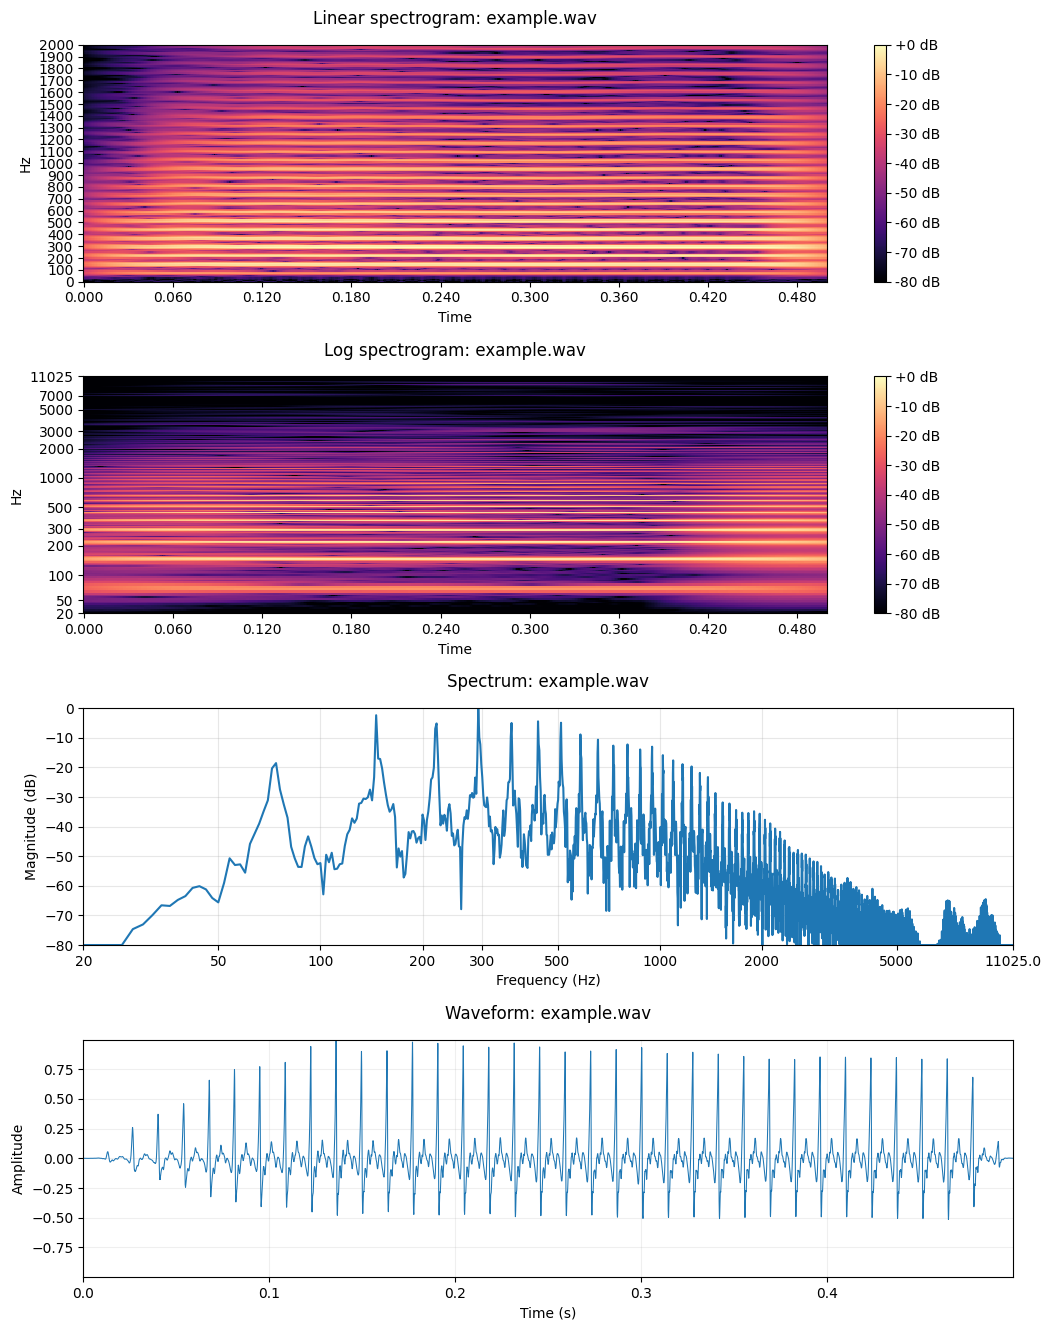

In [12]:
file = 'example.wav'
y, sr = librosa.load(file,sr=22050)
title = os.path.basename(file) 

y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS) 
# Create fig and ax objects
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

plot_spectrogram(y, sr, fig, ax1, **SPEC_PARAMS['linear'], title=title)
plot_spectrogram(y, sr, fig, ax2, **SPEC_PARAMS['log'], title=title)
plot_spectrum(y, sr, fig, ax3, title=title)
plot_time(y, sr, fig, ax4, title=title)

plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)


plt.show()
Audio(y, rate=sr)

### Batch processing




##### PDF Option 1: All plot types per audio file in folder

In [13]:
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

INPUT_FOLDER = './samples/singlenotes_nofades/york/aom5024/'
OUTPUT_PATH = './PDFs/york/york_notes_aom5024.pdf'

# Create output directory if it doesn't exist
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

with PdfPages(OUTPUT_PATH) as pdf:
    # Create the specs page
    create_specs_page(pdf, input_folders=INPUT_FOLDER, multi_plot=True)

    # Process all wav files in folder alphabetically
    wav_files = sorted(Path(INPUT_FOLDER).glob('*.wav'))
    for file in wav_files:
        # Load audio
        y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
        title = os.path.basename(file)
        y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
        y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
        
        # Create a figure with three subplots
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(PLOT_WIDTH, PLOT_HEIGHT * 4))
        
        # Create plots in subplots
        plot_spectrogram(y, sr, fig, ax1, **SPEC_PARAMS['linear'], title=title)
        plot_spectrogram(y, sr, fig, ax2, **SPEC_PARAMS['log'], title=title)
        plot_spectrum(y, sr, fig, ax3, title=title)
        plot_time(y, sr, fig, ax4, title=title)
        
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### PDF Option 2: Same plot type across multiple files


In [14]:
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

# Configuration
PLOT_TYPE = 'SPECTROGRAM-LINEAR-Y'  # SPECTROGRAM-LINEAR-Y/SPECTROGRAM-LOG-Y/SPECTRUM/TIME
INPUT_FOLDER = './samples/singlenotes_nofades/york/aom5024/'
OUTPUT_PATH = f'./PDFs/York/{PLOT_TYPE}_aom5024.pdf'
ROWS = 2
COLUMNS = 1
PLOTS_PER_PAGE = ROWS * COLUMNS

# Create output directory if it doesn't exist
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)

with PdfPages(OUTPUT_PATH) as pdf:
    # Create specs page
    create_specs_page(pdf, plot_type=PLOT_TYPE, input_folders=INPUT_FOLDER, 
                     layout={'rows': ROWS, 'columns': COLUMNS})
    
    # Create initial figure
    fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(PLOT_WIDTH, PLOT_HEIGHT * ROWS))
    axes = [axes] if ROWS * COLUMNS == 1 else axes.flatten()
    plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)
    plot_count = 0

    for file in sorted(Path(INPUT_FOLDER).glob('*.wav')):
        # Load audio
        y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
        y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
        y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
        title = os.path.basename(file)
        
        # Make plot based on type
        if PLOT_TYPE == 'SPECTROGRAM-LINEAR-Y':
            plot_spectrogram(y, sr, fig, axes[plot_count], **SPEC_PARAMS['linear'], title=title)
        elif PLOT_TYPE == 'SPECTROGRAM-LOG-Y':
            plot_spectrogram(y, sr, fig, axes[plot_count], **SPEC_PARAMS['log'], title=title)
        elif PLOT_TYPE == 'SPECTRUM':
            plot_spectrum(y, sr, fig, axes[plot_count], title=title)
        elif PLOT_TYPE == 'TIME':
            plot_time(y, sr, fig, axes[plot_count], title=title)
        
        plot_count += 1
        
        if plot_count == PLOTS_PER_PAGE:
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)
            fig, axes = plt.subplots(ROWS, COLUMNS, figsize=(PLOT_WIDTH, PLOT_HEIGHT * ROWS))
            axes = [axes] if ROWS * COLUMNS == 1 else axes.flatten()
            plt.subplots_adjust(hspace=SUBPLOT_SPACING, wspace=SUBPLOT_SPACING)
            plot_count = 0
    
    if plot_count > 0:
        # Hide empty subplots
        for i in range(plot_count, PLOTS_PER_PAGE):
            axes[i].set_visible(False)
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)

##### PDF Option 3: Compare files across folders with same plot type


In [15]:
# Configuration
PLOT_TYPE = 'SPECTROGRAM-LINEAR-Y'  # Options: SPECTROGRAM-LINEAR-Y, SPECTROGRAM-LOG-Y, SPECTRUM, TIME
INPUT_FOLDERS = [
   './samples/singlenotes_nofades/york/aom5024/',
   './samples/singlenotes_nofades/yamaha/aom5024/',
   # Add more folders here as needed
]
OUTPUT_PATH = f'./PDFs/Comparison/{PLOT_TYPE.lower()}_comparison.pdf'  # Lowercase for cleaner filenames

# Create output directory and get files from all folders
Path(OUTPUT_PATH).parent.mkdir(parents=True, exist_ok=True)
files = [sorted(list(Path(folder).glob('*.wav'))) for folder in INPUT_FOLDERS]
folder_names = [Path(folder).parts[-1] for folder in INPUT_FOLDERS]

with PdfPages(OUTPUT_PATH) as pdf:
    create_specs_page(pdf, plot_type=PLOT_TYPE, input_folders=INPUT_FOLDERS)

    for i in range(max(len(f) for f in files)):
        fig, axes = plt.subplots(len(INPUT_FOLDERS), 1, 
                           figsize=(PLOT_WIDTH, PLOT_HEIGHT * len(INPUT_FOLDERS)))
        plt.subplots_adjust(hspace=SUBPLOT_SPACING)
        
        for ax, folder_files, name in zip(axes, files, folder_names):
            if i < len(folder_files):
                y, sr = librosa.load(str(folder_files[i]), sr=SAMPLE_RATE)
                y = trim(y, sr, 0, TRIM_DURATION_SECONDS)
                y = apply_hann_window_fades(y, sr, FADE_DURATION_SECONDS)
                title = folder_files[i].name  # Just use filename without folder name
                
                if PLOT_TYPE == 'SPECTROGRAM-LINEAR-Y':
                    plot_spectrogram(y, sr, fig, ax, **SPEC_PARAMS['linear'], title=title)
                elif PLOT_TYPE == 'SPECTROGRAM-LOG-Y':
                    plot_spectrogram(y, sr, fig, ax, **SPEC_PARAMS['log'], title=title)
                elif PLOT_TYPE == 'SPECTRUM':
                    plot_spectrum(y, sr, fig, ax, title=title)
                elif PLOT_TYPE == 'TIME':
                    plot_time(y, sr, fig, ax, title=title)
            else:
                ax.text(0.5, 0.5, f'No more files in {name} folder', ha='center', va='center')
                ax.set_title(f"{name} (empty)")
        
        plt.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)